In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import numpy as np
import regex as re
import seaborn as sns
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve
model = LogisticRegression(max_iter= 1200000)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data = pd.read_csv("Users/tejaswanidash/Desktop/HeLovesHisPatientsAndICanTellItsAboutUsAndNotTheMoney.csv")

In [ ]:
data.isnull().any()

commentId         False
comment           False
typeId            False
classification    False
loves             False
patients          False
tell              False
about             False
not               False
money             False
dtype: bool

# **Visualizing the dataset**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


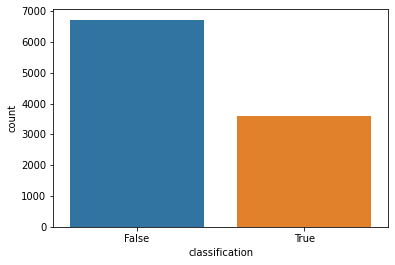

In [ ]:
sns.countplot(data.classification)

# **Removing Noise from the Data**

In [ ]:
def PreProcessing(comment):
    comment = comment.lower().replace('\n' ,' ').replace('\r', '').strip()
    comment = re.sub(' +', ' ', comment) 
    comment = re.sub(r'[^\w\s]', '',comment)
    
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    word_tokens = word_tokenize(comment)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(ps.stem(w))
    comment = ' '.join(filtered_sentence)
    return comment

In [ ]:
data['comment_cleaned'] = data['comment'].apply(PreProcessing)
labels = data['classification'].tolist()

In [ ]:
def Changelabels(data):
  for i, n in enumerate(data):
    if n == True:
        data[i] = -1
    elif n == False:
      data[i] = 1
  return data      
labels = Changelabels(labels)


# **Splitting data into train and test**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, Y_train, Y_test = train_test_split(data['comment_cleaned'], labels, test_size = 0.4, random_state = 42)

In [ ]:
Y_train = np.array(Y_train).reshape((len(Y_train), 1))

# **Converting comments to vectors using Doc2Vec**

In [ ]:
def labels(corpus, label_type):
    labeled = []
    for i, word in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(word.split(), [label]))
    return labeled


In [ ]:
X_train = labels(x_train, 'Train')
X_test = labels(x_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_doc = Doc2Vec(dm=0, vector_size=800, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_doc.build_vocab([x for x in (all_data)])

for epoch in range(30):
    model_doc.train(utils.shuffle([x for x in (all_data)]), total_examples=len(all_data), epochs=1)
    model_doc.alpha -= 0.002
    model_doc.min_alpha = model_doc.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
  vectors = np.zeros((corpus_size, vectors_size))
  for i in range(0, corpus_size):
    prefix = vectors_type + '_' + str(i)
    vectors[i] = model.docvecs[prefix]

  return vectors  



In [ ]:
features_train = get_vectors(model_doc, len(X_train), 800, 'Train')
features_test = get_vectors(model_doc, len(X_test), 800, 'Test')

#**Initializing the weights and bias from normal distribution**

In [ ]:
# w = np.zeros((1, features_train.shape[1]))
# b = np.zeros((1,1))

w = np.random.normal(0, 0.01, (1, features_train.shape[1]))
b = np.random.normal(0, 0.01, (1,1))

# **Logistic Regression from Scratch**

In [ ]:
def sigmoid(w, b, x_train):
  x = x_train.dot(w.T) + b
  sigma = 1/(1 + np.exp(-x))
  return sigma

# **Updating Weights**

In [ ]:
def update_weights(eta, w, b, x_train, y_train, epochs):
  sigma = sigmoid(w, b, x_train)
  tmp = ( sigma - y_train )
  dw = np.dot(x_train.T, tmp)
  dw = dw / y_train.shape[0]
  W = dw.T
  db = np.sum(tmp) / x_train.shape[0]
  w = w - eta * W
  b = b - eta * db

  return w , b 

In [ ]:
def LogisticRegression(eta, epochs, w, b, x_train, y_train):

  for i in range(epochs):
    w, b = update_weights(eta, w, b, x_train, y_train, i)
  return w, b

In [ ]:
learningrate = 0.000001
epochs = 100
w_updated, b_updated = LogisticRegression(learningrate, epochs,w, b, features_train, Y_train.reshape((len(Y_train), 1)) )

# **Predicting the labels for test data**

In [ ]:
def Predictions(x_test, w_updated, b_updated):
  z = sigmoid(w_updated, b_updated, x_test)
  Y = np.where( z > 0.5, 1, -1 ) 
  return Y       



In [ ]:
predictions = Predictions(features_test, w_updated, b_updated).tolist()

In [ ]:
predicted_labels = []
for i in range(len(predictions)):
  predicted_labels.append(predictions[i][0])

In [ ]:
print('Accuracy', accuracy_score(Y_test, predicted_labels))
print(classification_report(Y_test, predicted_labels))
print("Confusion Matrix\n",confusion_matrix(Y_test, predicted_labels))
print("F1 Score",f1_score(Y_test, predicted_labels))

fpr, tpr, thr = roc_curve(Y_test, predictions)



Accuracy 0.645919108743037
              precision    recall  f1-score   support

          -1       0.43      0.15      0.22      1398
           1       0.67      0.90      0.77      2731

    accuracy                           0.65      4129
   macro avg       0.55      0.52      0.50      4129
weighted avg       0.59      0.65      0.58      4129

Confusion Matrix
 [[ 205 1193]
 [ 269 2462]]
F1 Score 0.7710616974632009


# **Plotting ROC Curve**

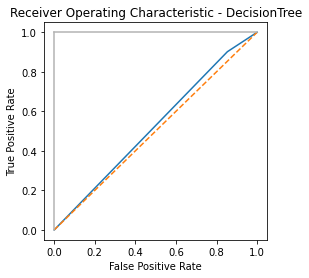

In [ ]:
plt.subplots(1, figsize=(4,4))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#**Predicting Lables using Logistic Regression Library**

In [ ]:
model.fit(features_train, Y_train)
predictions = model.predict(features_test)
print('Accuracy', accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))
print("Confusion Matrix\n",confusion_matrix(Y_test, predictions))
print("F1 Score",f1_score(Y_test, predictions))
fpr, tpr, thr = roc_curve(Y_test, predictions)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy 0.7294744490191329
              precision    recall  f1-score   support

          -1       0.64      0.45      0.53      1398
           1       0.76      0.87      0.81      2731

    accuracy                           0.73      4129
   macro avg       0.70      0.66      0.67      4129
weighted avg       0.72      0.73      0.71      4129

Confusion Matrix
 [[ 627  771]
 [ 346 2385]]
F1 Score 0.8102598946832003


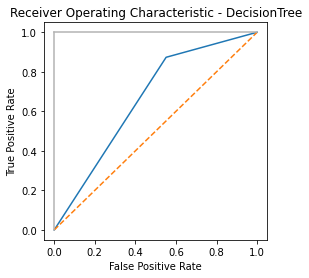

In [ ]:
plt.subplots(1, figsize=(4,4))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#**Converting comments to vectors using TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 800, ngram_range=(1,2), min_df = 10, max_df = 1.0, norm='l2')
train_features = vectorizer.fit_transform(x_train).toarray()
test_features = vectorizer.transform(x_test).toarray()
Y_train = Y_train.reshape((features_train.shape[0], 1))

In [ ]:
model.fit(train_features, Y_train)
predictions = model.predict(test_features)
print('Accuracy', accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))
print("Confusion Matrix\n",confusion_matrix(Y_test, predictions))
print("F1 Score",f1_score(Y_test, predictions))
fpr, tpr, thr = roc_curve(Y_test, predictions)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy 0.7553887139743279
              precision    recall  f1-score   support

          -1       0.70      0.49      0.57      1398
           1       0.77      0.89      0.83      2731

    accuracy                           0.76      4129
   macro avg       0.74      0.69      0.70      4129
weighted avg       0.75      0.76      0.74      4129

Confusion Matrix
 [[ 680  718]
 [ 292 2439]]
F1 Score 0.8284646739130435


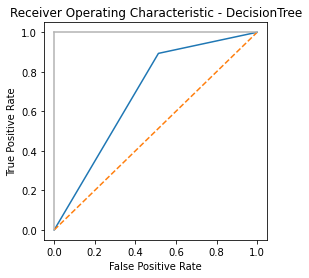

In [ ]:
plt.subplots(1, figsize=(4,4))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
